- ## Notebook for model creation with 500 trials to test if there is any better performance in 100 vs 500 trials
- #### Morgan / Taylor's labeled sentences added in this version

- This file creates model with MORE labelled data (Coded Sentences Drawn from Civic Center's Research and Taylor (1892_labeled_sentences.csv). Renamed "Label" column to "jim_crow".
- Added 11 updated files with correct splitting and coded by Axton : 1868_24-25_updated, 1868_143-145_updated, 1868_146-151_updated, 1877_571-586_updated.csv, 1884_24-26_updated.csv, 1886-87_1031-1034_updated.csv, 1886-87_1072-1074_updated.csv,1868_24-25_updated, 1896_63act_updated, 1907_518-522_updated, 1925_324act_updated, shared_base_training_set_v2.csv (from UNC)
- Converted the excel files coded by Axton to csv
- Renamed the above files to make the naming consistent (- replaced by _, added 'labeled_sentences')
- Renamed the column 'Coding (Axton)" of Civic Center data to 'jim_crow' , 'Act' to 'sentence' and 'Year' to 'year' for consistency
- Added column state = 'South Carolina' in all Civic Center coded files
- Replaced the 'year' values in file 1886_87_1031-1034.csv from '1886-87' to 1886 and '1868_146-151_updated.csv' from '1868-69' to 1868
- Changed case in some column names (upper to lower)
- Read "UNC_shared_base_training_set_v2.csv" file differently to perform some filteration as mentioned by Matthew Jansen (UNC) 
- CASE 1: Training and testing model on combined data of UNC and USC
- CASE 2: Training model on UNC data and testing model on USC data

- **Used SMOTEN to rebalance the imbalanced dataset and removed stopwords but the model performance did not improve in comparison to without SMOTEN/stopword removal.**
- **The time taken to create the model is very less than the time taken without SMOTEN/stopwords removal.**
- **This code also predicts labels for the WHOLE CORPUS and for EACH YEAR**

## Case 1: Training and testing model on both USC and UNC data

### Import neccessary libraries

In [1]:
# data reading libraries
import numpy as np
import pandas as pd
from pathlib import Path

#Saving model so that we don't have to run it every time we open this notebook
import pickle 

# Text Libraries
import re
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords') 

# Machine Learning Libraries
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTEN
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer

#Model Tuning Libraries
from hyperopt import hp, tpe, space_eval, Trials
from hyperopt.fmin import fmin

#Evaluation Libraries
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score

#Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

#Supression
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vandana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read the data and store in dataframe

In [2]:
# Read data from the folder "LabeledData". Since one file "UNC_shared_base_training_set_v2.csv" is different from others, we are 
# reading it separately from others.
new_df = pd.DataFrame()

for file in Path("LabeledData_UNC_USC_Feb2024").glob('*.csv'):
    if str(file).find("base") != -1 :
        df1 = pd.read_csv(file)       # reading the "UNC_shared_base_training_set_v2.csv" file and store it in dataframe df1
    else: 
        df = pd.read_csv(file, usecols=['year', 'state','sentence', 'jim_crow'])
        new_df = new_df.append(df, ignore_index = True)

In [3]:
# Read first 5 rows of "UNC_shared_base_training_set_v2.csv" file whose columns are different from other csv files
df1[['jim_crow']] = df1[['jim_crow']].astype(int) # Change the datatype of jim_crow" to int in df1 (it is 0.0, 1.0, 2.0 currently)
df1.head()

,corpus_section_id,source,law_type,UNC_training,state,sentence,section_sents,char_len,reviewer,jim_crow,jim_crow_type,year,corpus_sentence_id
0,1947_session laws_979_2,murray,session laws,1.0,NORTH CAROLINA,Subject only to restrictions and conditions no...,1.0,779.0,NaN,1,explicit,1947,NaN
1,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,Powers and duties of Commission.,10.0,32.0,Axton,0,explicit,1935,NaN
2,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,The said Textbook Purchase and Rental Commissi...,10.0,146.0,Axton,0,explicit,1935,NaN
3,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,"Acquire by contract, and/or purchase, such tex...",10.0,53.0,Axton,0,explicit,1935,NaN
4,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,"and instructional supplies, which are, or may ...",10.0,218.0,Axton,0,explicit,1935,NaN


In [4]:
# find length of df1
len(df1)

10231

#### Only select rows which have a 'jim_crow' value of either 0 or 1
df.loc[df.jim_crow.isin([0,1]), :]

#### Only select rows which have a 'jim_crow_type' value of 'extrinsic' or 'implicit'
df.loc[df.jim_crow_type.isin(["extrinsic","implicit"]), :]

#### Only select rows which DONT have a 'jim_crow_type' value of 'extrinsic' or 'implicit' by using '~'
df.loc[~df.jim_crow_type.isin(["extrinsic","implicit"]), :]

In [5]:
# Only select those rows which have value of either 0 or 1 in "jim_crow" column AND do not have value of "extrinsic" or 
# "intrinsic" in "jim_crow_type" column ---- as suggested by Matt Jansen (UNC)
df1_good = df1.loc[(df1.jim_crow.isin([0,1])) & (~df1.jim_crow_type.isin(["extrinsic","implicit"])),:].copy()
df1_good.head()

,corpus_section_id,source,law_type,UNC_training,state,sentence,section_sents,char_len,reviewer,jim_crow,jim_crow_type,year,corpus_sentence_id
0,1947_session laws_979_2,murray,session laws,1.0,NORTH CAROLINA,Subject only to restrictions and conditions no...,1.0,779.0,NaN,1,explicit,1947,NaN
1,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,Powers and duties of Commission.,10.0,32.0,Axton,0,explicit,1935,NaN
2,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,The said Textbook Purchase and Rental Commissi...,10.0,146.0,Axton,0,explicit,1935,NaN
3,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,"Acquire by contract, and/or purchase, such tex...",10.0,53.0,Axton,0,explicit,1935,NaN
4,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,"and instructional supplies, which are, or may ...",10.0,218.0,Axton,0,explicit,1935,NaN


In [6]:
# Create a new dataframe from df1_good that has columns same as new_df
new_df1 = df1_good[['year', 'state', 'sentence', 'jim_crow']]
new_df1

,year,state,sentence,jim_crow
0,1947,NORTH CAROLINA,Subject only to restrictions and conditions no...,1
1,1935,NORTH CAROLINA,Powers and duties of Commission.,0
2,1935,NORTH CAROLINA,The said Textbook Purchase and Rental Commissi...,0
3,1935,NORTH CAROLINA,"Acquire by contract, and/or purchase, such tex...",0
4,1935,NORTH CAROLINA,"and instructional supplies, which are, or may ...",0
...,...,...,...,...
10225,1909,NORTH CAROLINA,On behalf of the general welfare of the city o...,0
10226,1895,NORTH CAROLINA,"The clerk of the commissioners, on or before t...",1
10228,1899,NORTH CAROLINA,The township school trustees shall divide thei...,0
10229,1899,NORTH CAROLINA,They shall consult the convenience and necessi...,1


### Data Cleaning and Exploration

In [7]:
# display first 5 rows of the data new_df
new_df.head()

,year,state,sentence,jim_crow
0,1896,SOUTH CAROLINA,it shall be the duty of each county treasurer ...,0.0
1,1896,SOUTH CAROLINA,all moneys disbursed by any county treasurer o...,0.0
2,1896,SOUTH CAROLINA,each county treasurer shall make out and forwa...,0.0
3,1896,SOUTH CAROLINA,the county treasurer shall carry forward all s...,0.0
4,1896,SOUTH CAROLINA,"it shall be unlawful for any county treasurer,...",0.0


In [8]:
new_df

,year,state,sentence,jim_crow
0,1896,SOUTH CAROLINA,it shall be the duty of each county treasurer ...,0.0
1,1896,SOUTH CAROLINA,all moneys disbursed by any county treasurer o...,0.0
2,1896,SOUTH CAROLINA,each county treasurer shall make out and forwa...,0.0
3,1896,SOUTH CAROLINA,the county treasurer shall carry forward all s...,0.0
4,1896,SOUTH CAROLINA,"it shall be unlawful for any county treasurer,...",0.0
...,...,...,...,...
27067,1868-69,SOUTH CAROLINA,each surveyor shall keep fair and regular acco...,0.0
27068,1868-69,SOUTH CAROLINA,and it shall be the duty of such surveyor to p...,0.0
27069,1868-69,SOUTH CAROLINA,if any surveyor shall have failed to collect t...,0.0
27070,1868-69,SOUTH CAROLINA,if any person receive or suffer bodily injury ...,0.0


In [9]:
#replace '1886-87' in "year" column by 1886 and '1868-69' by 1868
new_df.replace('1886-87', '1886', inplace=True)
new_df.replace('1868-69', '1868', inplace=True)
new_df[new_df['year'] == '1868-69'].head() # emplty dataframe because we have replaced "1886-87" by "1886"

,year,state,sentence,jim_crow


In [10]:
# find the size of each dataframe
print(" The length of new_df is", len(new_df))
print(" The length of new_df1 is", len(new_df1))

 The length of new_df is 27072
 The length of new_df1 is 9492


In [11]:
# Check how many entries are null or empty in the two datasets
print(new_df.isnull().sum().sum())
print(new_df1.isnull().sum().sum())

13086
0


##### Remove all the null entries - coming from the 3 files shared by Morgan/Taylor

In [12]:
new_df_clean = new_df.dropna(subset=['jim_crow'])
print(new_df_clean.isnull().sum().sum())

0


In [13]:
# find the data types of columns of new_df1 and new_df
print("Column datatypes of new_df_clean are below: \n", new_df_clean.dtypes)
print("Column datatypes of new_df1 are below: \n", new_df1.dtypes)

Column datatypes of new_df_clean are below: 
 year         object
state        object
sentence     object
jim_crow    float64
dtype: object
Column datatypes of new_df1 are below: 
 year         int64
state       object
sentence    object
jim_crow     int64
dtype: object


Make sure that the data type of the two dataframes are SAME as we are going to append the datasets to create ONE large dataset

In [14]:
# Change the datatype of "year" and "jim_crow" to string in new_df1 
#new_df1[['jim_crow']] = new_df1[['jim_crow']].astype(int)
#new_df1[['year']] = new_df1[['year']].astype(str)

# # Change the datatype of 'year' to string in new_df
new_df_clean[['year']] = new_df_clean[['year']].astype(int)
new_df_clean[['jim_crow']] = new_df_clean[['jim_crow']].astype(int)

In [15]:
# find the data types of columns of new_df1 and new_df after changing
print("Column datatypes of new_df_clean are below: \n", new_df_clean.dtypes)
print("Column datatypes of new_df1 are below: \n", new_df1.dtypes)

Column datatypes of new_df_clean are below: 
 year         int64
state       object
sentence    object
jim_crow     int64
dtype: object
Column datatypes of new_df1 are below: 
 year         int64
state       object
sentence    object
jim_crow     int64
dtype: object


In [16]:
new_df.year.unique()


array([1896, 1907, '1886', 1937, 1922, 1877, 1879, 1898, 1900, 1903, 1904,
       1905, 1908, 1909, 1910, 1911, 1912, 1914, 1915, 1916, 1917, 1918,
       1920, 1924, 1926, 1928, 1930, 1934, 1872, 1878, 1906, 1891, 1923,
       1935, 1938, 1939, 1940, 1943, 1944, 1945, 1947, 1933, 1927, 1925,
       1913, 1899, 1901, 1941, 1949, 1889, 1887, 1885, 1883, 1881, 1880,
       1897, 1893, 1895, 1929, 1931, 1919, 1955, 1959, 1967, 1965, 1957,
       1869, 1963, 1951, 1868, 1961, 1870, 1921, 1953, 1876, 1871, 1866,
       1874, 1873, 1956, 1888, 1952, 1892, 1884, '1868'], dtype=object)

#### Append the 2 datasets to create a big labeled dataset

In [17]:
# Create a large dataset with the 2 separate datasets
combined_df = new_df_clean.append(new_df1,ignore_index = True)

#find the length of combined dataset
print(len(combined_df))

23479


In [18]:
# save the combined data to csv file
combined_df.to_csv("combined.csv")

In [19]:
# Convert column 'sentence' to lowercase use map()
combined_df['sentence'] = combined_df['sentence'].map(str.lower)
combined_df

,year,state,sentence,jim_crow
0,1896,SOUTH CAROLINA,it shall be the duty of each county treasurer ...,0
1,1896,SOUTH CAROLINA,all moneys disbursed by any county treasurer o...,0
2,1896,SOUTH CAROLINA,each county treasurer shall make out and forwa...,0
3,1896,SOUTH CAROLINA,the county treasurer shall carry forward all s...,0
4,1896,SOUTH CAROLINA,"it shall be unlawful for any county treasurer,...",0
...,...,...,...,...
23474,1909,NORTH CAROLINA,on behalf of the general welfare of the city o...,0
23475,1895,NORTH CAROLINA,"the clerk of the commissioners, on or before t...",1
23476,1899,NORTH CAROLINA,the township school trustees shall divide thei...,0
23477,1899,NORTH CAROLINA,they shall consult the convenience and necessi...,1


In [20]:
# Count of North Carolina and SOuth Carolina sentences
count_df = combined_df.groupby('state').count()
count_df

,year,sentence,jim_crow
state,,,
NORTH CAROLINA,14913,14913,14913
SOUTH CAROLINA,8566,8566,8566


In [21]:
# find length of each sentence
combined_df['sent_length'] = combined_df['sentence'].str.len()
combined_df

,year,state,sentence,jim_crow,sent_length
0,1896,SOUTH CAROLINA,it shall be the duty of each county treasurer ...,0,533
1,1896,SOUTH CAROLINA,all moneys disbursed by any county treasurer o...,0,249
2,1896,SOUTH CAROLINA,each county treasurer shall make out and forwa...,0,808
3,1896,SOUTH CAROLINA,the county treasurer shall carry forward all s...,0,320
4,1896,SOUTH CAROLINA,"it shall be unlawful for any county treasurer,...",0,318
...,...,...,...,...,...
23474,1909,NORTH CAROLINA,on behalf of the general welfare of the city o...,0,365
23475,1895,NORTH CAROLINA,"the clerk of the commissioners, on or before t...",1,477
23476,1899,NORTH CAROLINA,the township school trustees shall divide thei...,0,136
23477,1899,NORTH CAROLINA,they shall consult the convenience and necessi...,1,282


In [22]:
# find the max and min length of the sentence
print(" The longest sentence is of length:", combined_df['sent_length'].max())

# find the index of the row with longest sentence
combined_df.index[combined_df['sent_length'] == 8889]

 The longest sentence is of length: 8889


Int64Index([5493, 15570], dtype='int64')

In [23]:
combined_df.iloc[5298,:]

year                                                        1901
state                                             NORTH CAROLINA
sentence       that j. n. price, h. l. price, e. m. moore, l....
jim_crow                                                       0
sent_length                                                 1115
Name: 5298, dtype: object

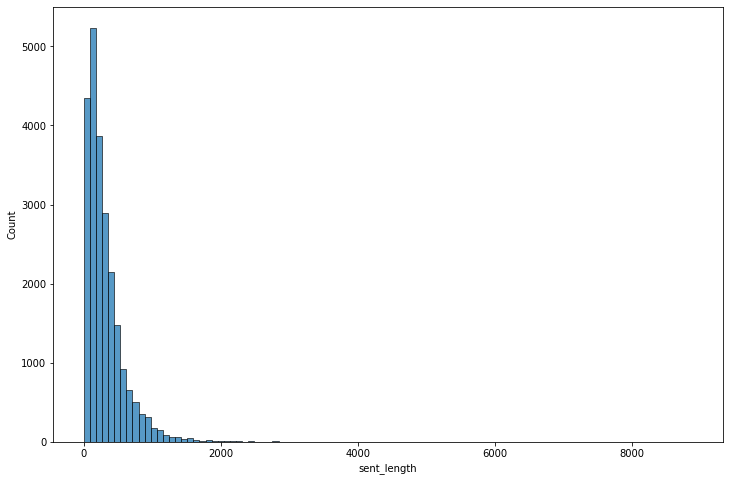

In [24]:

fig, ax = plt.subplots(1,1, figsize=(12,8))
# Histogram for the sentence length
sns.histplot(data=df, x=combined_df['sent_length'], bins = 100, ax=ax)


In [25]:
# find the rows whose sentence length is less than 27 words
combined_df_27char = combined_df[combined_df['sent_length'] < 27]
combined_df_27char.to_csv("combined_df_27char.csv")

# Find the number of sentences with labels "0", "1", and "2" in the dataframe with less than 27 charcters
df0 = combined_df_27char[combined_df_27char['jim_crow'] == 0]
df1 = combined_df_27char[combined_df_27char['jim_crow'] == 1]
df2 = combined_df_27char[combined_df_27char['jim_crow'] == 2]
print(df0)
print(df1)
print(df2)

       year           state                    sentence  jim_crow  sent_length
58     1907  SOUTH CAROLINA    provided, further, that.         0           24
73     1886  SOUTH CAROLINA      officers of the board.         0           22
74     1886  SOUTH CAROLINA                   meetings.         0            9
76     1886  SOUTH CAROLINA           local school tax.         0           17
79     1886  SOUTH CAROLINA  and protected by his bond.         0           26
...     ...             ...                         ...       ...          ...
18113  1939  NORTH CAROLINA         purpose of the act.         0           20
18115  1939  NORTH CAROLINA              appropriation.         0           14
18154  1899  NORTH CAROLINA                           :         0            1
18215  1907  NORTH CAROLINA                           q         0            1
18219  1905  NORTH CAROLINA       manner of assessment.         0           21

[681 rows x 5 columns]
       year           state 

- The number of sentences less than 25 characters are 463 and they are all labeled as 0 except one (labeled 2). So, we can delete all senetences whose length are less than 25.
- The number of sentences less than 27 characters are 684 and they are all labeled as 0 except three (one labeled 1, two lableled 2). Since we do not want to delete any sentence coded as 1, we will delete all sentences less than 22 characters.

#### Remove all the sentences with < 22 characters. Create dataset with >= 22 characaters

In [26]:
# Remove all the sentences whose length is <= characters
df_updated = combined_df[combined_df['sent_length'] >= 22]
print(" Number of rows in the reduced dataset:", len(df_updated))

 Number of rows in the reduced dataset: 23041


In [27]:
# find the data type of reduced dataframe columns
df_updated.dtypes

year            int64
state          object
sentence       object
jim_crow        int64
sent_length     int64
dtype: object

In [28]:
# Find the number of sentences with labels "0", "1", and "2"
df_0 = df_updated[df_updated['jim_crow'] == 0]
df_1 = df_updated[df_updated['jim_crow'] == 1]
df_2 = df_updated[df_updated['jim_crow'] == 2]

print("Number of sentences that are NOT jim crow =", len(df_0))
print("Number of jim crow sentences =", len(df_1))
print("Number of undecided sentences =", len(df_2))

Number of sentences that are NOT jim crow = 18056
Number of jim crow sentences = 4318
Number of undecided sentences = 667


In [29]:
df_updated.dtypes

year            int64
state          object
sentence       object
jim_crow        int64
sent_length     int64
dtype: object

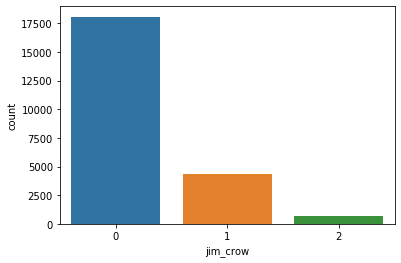

In [30]:
from seaborn import countplot

# Plot the distribution of the target (=1 that is jim_crow)
countplot(x=df_updated['jim_crow'])

In [31]:
# Check for missing values
df_updated.isnull().sum().sum()

0

In [32]:
df_updated.head()

,year,state,sentence,jim_crow,sent_length
0,1896,SOUTH CAROLINA,it shall be the duty of each county treasurer ...,0,533
1,1896,SOUTH CAROLINA,all moneys disbursed by any county treasurer o...,0,249
2,1896,SOUTH CAROLINA,each county treasurer shall make out and forwa...,0,808
3,1896,SOUTH CAROLINA,the county treasurer shall carry forward all s...,0,320
4,1896,SOUTH CAROLINA,"it shall be unlawful for any county treasurer,...",0,318


In [33]:
df_0 = df_updated[df_updated['jim_crow'] == 9]
df_0

,year,state,sentence,jim_crow,sent_length


#### Removing stopwords from the sentences

In [34]:
stopWords = stopwords.words("english")

# Define a function to remove stop words from a sentence 
def remove_stop_words(sentence): 
  # Split the sentence into individual words 
    words = sentence.split() 
  
  # Use a list comprehension to remove stop words 
    filtered_words = [word for word in words if word not in stopWords] 
  
  # Join the filtered words back into a sentence 
    return ' '.join(filtered_words)

In [35]:
# Remove stopwords from the 'sentence' column of the dataframe
p=[]
for i in df_updated['sentence']:
    p.append(remove_stop_words(i))
df_updated['sentence']=p
df_updated['sentence']

0        shall duty county treasurer report monthly, fi...
1        moneys disbursed county treasurer account scho...
2        county treasurer shall make forward state supe...
3        county treasurer shall carry forward sums hand...
4        shall unlawful county treasurer, county audito...
                               ...                        
23474    behalf general welfare city winston, good orde...
23475    clerk commissioners, first monday november lis...
23476    township school trustees shall divide respecti...
23477    shall consult convenience necessities race set...
23478    treasurer wilkes county hereby authorized pay ...
Name: sentence, Length: 23041, dtype: object

### Split the data into 'features' and 'target' for machine learning 

In [36]:
# Split data
features = df_updated[['year', 'sentence']]
target = df_updated['jim_crow']

In [37]:
print(features.shape, target.shape)

(23041, 2) (23041,)


In [38]:
features

,year,sentence
0,1896,"shall duty county treasurer report monthly, fi..."
1,1896,moneys disbursed county treasurer account scho...
2,1896,county treasurer shall make forward state supe...
3,1896,county treasurer shall carry forward sums hand...
4,1896,"shall unlawful county treasurer, county audito..."
...,...,...
23474,1909,"behalf general welfare city winston, good orde..."
23475,1895,"clerk commissioners, first monday november lis..."
23476,1899,township school trustees shall divide respecti...
23477,1899,shall consult convenience necessities race set...


### Machine Learning: XGBoost 

- Splitting test and training set in 20|80 ratio
- Using default values of the parameter
- Training and test set contains mixed of NC and SC sentences
- Resample training data using imblearn SMOTEN as the dataset is very imbalanced - using SMOTEN because our dataset is purely categorical (https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTEN.html#imblearn.over_sampling.SMOTEN)

In [39]:
# Randomly split X and y into training (80%) and test(20%) sets

X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size = 0.2, 
                                                    random_state = 13)

In [40]:
print("......TRAINING SET....")
print(" Size of X_train is: ", X_train.shape)
print(" Size of y_train is: ", y_train.shape)
print("......TEST SET....")
print(" Size of X_test is: ", X_test.shape)
print(" Size of y_test is: ", y_test.shape)


......TRAINING SET....
 Size of X_train is:  (18432, 2)
 Size of y_train is:  (18432,)
......TEST SET....
 Size of X_test is:  (4609, 2)
 Size of y_test is:  (4609,)


#### Count of 0,1,2 in training set BEFORE resampling using SMOTEN

In [41]:
# Counting 0,1,2 in y_train 
np.array(np.unique(y_train, return_counts=True)).T

array([[    0, 14505],
       [    1,  3383],
       [    2,   544]])

In [42]:
X_train.dtypes

year         int64
sentence    object
dtype: object

#### Resample the data using SMOTEN

In [43]:
sm = SMOTEN(random_state=13)
X_train, y_train = sm.fit_resample(X_train, np.array(y_train))
len(X_train)

43515

#### Count of 0,1,2 in training set AFTER resampling using SMOTEN

In [44]:
# count of 0,1,2 after using SMOTEN
np.array(np.unique(y_train, return_counts=True)).T

array([[    0, 14505],
       [    1, 14505],
       [    2, 14505]])

### Create pipeline for the analysis

In [45]:
class SelectColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def transform(self, X, **transform_params):
        out = X[self.columns].copy()
        return out
    def fit(self, X, y=None, **fit_params):
        return self

##### Bayesian Hyperparameter search with HyperOpt

In [46]:
pipeline = Pipeline([

        ('features', FeatureUnion([

            # Extract features
            ('text_pipeline', Pipeline([
                ('get_text', SelectColumnsTransformer("sentence")),
                ('vect', CountVectorizer(decode_error = "ignore",
                      min_df = 2, max_df = 0.8)),
                ('tfidf', 'passthrough'),
            ])),
#             ('text_len', Pipeline([
#                 ('get_text', SelectColumnsTransformer("sentence")),
#                 ('length', LengthExtractor())
#             ])),
            ('metadata', SelectColumnsTransformer(['year']))
        ])),
        ('dlf',XGBClassifier(tree_method="hist"))
])

In [47]:
def objective(params):
    params['features__text_pipeline__vect__min_df'] = int(params['features__text_pipeline__vect__min_df'])
    params['dlf__max_depth'] = int(params['dlf__max_depth'])
    params['dlf__min_child_weight'] = int(params['dlf__min_child_weight'])
    params['dlf__scale_pos_weight'] = int(params['dlf__scale_pos_weight'])
    pipeline.set_params(**params)
    
    score = 1-cross_val_score(pipeline, X_train, y_train, scoring=make_scorer(f1_score, average="weighted"),
                              n_jobs=-1).mean()
    #print("F1 {:.4f} params {}".format((1-score), params))
    return score

space = {
    'features__text_pipeline__vect__min_df': hp.quniform ('features__text_pipeline__vect__min_df',2,20,1),
    'features__text_pipeline__vect__lowercase': hp.choice('features__text_pipeline__vect__lowercase',[True,False]),
    'features__text_pipeline__vect__ngram_range': hp.choice('features__text_pipeline__vect__ngram_range',[(1,1),(1,2),(1,3),(1,4)]),
    'features__text_pipeline__vect__max_df': hp.uniform('features__text_pipeline__vect__max_df',0.6,0.8),
#     'features__text_len':hp.choice('features__text_len',[Pipeline([
#             ('get_text', SelectColumnsTransformer("sentence")),
#             ('length', LengthExtractor())
#         ])]),
    'dlf__max_depth': hp.quniform('dlf__max_depth', 2, 10, 1),
    'dlf__min_child_weight': hp.quniform('dlf__min_child_weight', 1, 5, 1),
    'dlf__colsample_bytree': hp.uniform('dlf__colsample_bytree', 0.3, 1.0),
    'dlf__learning_rate': hp.uniform('dlf__learning_rate', 0.05, 1),
    'dlf__scale_pos_weight': hp.quniform('dlf__scale_pos_weight',1,8,1),
    'dlf__gamma': hp.uniform('dlf__gamma',0,2)
    
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=500, #actual fit was run with 1000 evals
           trials=trials)

100%|██████████| 500/500 [2:23:29<00:00, 17.22s/trial, best loss: 0.029639438994228606]  


In [79]:
model_params = space_eval(space, best)
model_params['features__text_pipeline__vect__min_df'] = int(model_params['features__text_pipeline__vect__min_df'])
model_params['dlf__max_depth'] = int(model_params['dlf__max_depth'])
model_params['dlf__min_child_weight'] = int(model_params['dlf__min_child_weight'])
# model_params['dlf__scale_pos_weight'] = int(model_params['dlf__scale_pos_weight'])

In [80]:
model_params

{'dlf__colsample_bytree': 0.6870442090013855,
 'dlf__gamma': 0.0597211976024812,
 'dlf__learning_rate': 0.19932436247952773,
 'dlf__max_depth': 10,
 'dlf__min_child_weight': 1,
 'dlf__scale_pos_weight': 7.0,
 'features__text_pipeline__vect__lowercase': True,
 'features__text_pipeline__vect__max_df': 0.6000830305620343,
 'features__text_pipeline__vect__min_df': 8,
 'features__text_pipeline__vect__ngram_range': (1, 4)}

#### Fit the best parameters to the training set

In [81]:
best_model = pipeline
best_model.set_params(**model_params)
best_model.fit(X_train,y_train)

[20:22:14] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:22:14] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('get_text',
                                                                  SelectColumnsTransformer(columns='sentence')),
                                                                 ('vect',
                                                                  CountVectorizer(decode_error='ignore',
                                                                                  max_df=0.6000830305620343,
                                                                                  min_df=8,
                                                                                  ngram_range=(1,
                                                                                               4))),
                                                                 ('tfidf',
                                                            

#### Design confusion matrix

[Text(0.5, 1, 'Overall')]

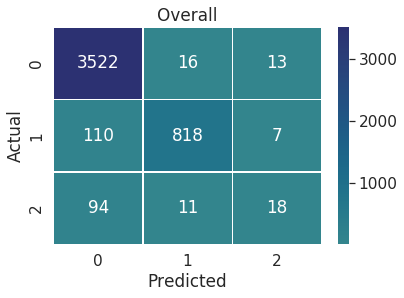

In [82]:
#predict the labels of test data 
y_pred = best_model.predict(X_test)

# count the number of labels
labels = np.unique(y_pred)

data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

# use sns.heatmap on top of confusion_matrix to show the confusion matrix
sns.set(font_scale=1.4)
ax = sns.heatmap(df_cm,xticklabels=True, annot=True, fmt='.0f', center=0.8, cmap='crest', linewidth=.5)
ax.set(title="Overall")

In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3551
           1       0.97      0.87      0.92       935
           2       0.47      0.15      0.22       123

    accuracy                           0.95      4609
   macro avg       0.80      0.67      0.70      4609
weighted avg       0.94      0.95      0.94      4609



## Predict "label" for the whole corpus

In [84]:
corpus = pd.read_csv('../Split_Cleanup_Updated/updated_results/final_splits_Nov3.csv')

In [85]:
corpus.head()

,id,law_type,state,sentence,length,start_page,end_page,act,section,path
0,1868-69_0000,Act,SOUTH CAROLINA,AN ACT ACCEPTING THE BENEFITS OF AN ACT DONATI...,285,71,71,1,0,https://emailsc.sharepoint.com/:i:/r/sites/COT...
1,1868-69_0001,Act,SOUTH CAROLINA,"Whereas, by an Act of Congress, approved the t...",1161,71,71,1,0,https://emailsc.sharepoint.com/:i:/r/sites/COT...
2,1868-69_0002,Act,SOUTH CAROLINA,Beit enacted by the Senate and House of Repres...,979,71,72,1,1,https://emailsc.sharepoint.com/:i:/r/sites/COT...
3,1868-69_0003,Act,SOUTH CAROLINA,"Upon the passage of this Act, the Governor of ...",197,72,72,1,2,https://emailsc.sharepoint.com/:i:/r/sites/COT...
4,1868-69_0004,Act,SOUTH CAROLINA,"In the Senate House, the twentysecond day of J...",122,72,72,1,1,https://emailsc.sharepoint.com/:i:/r/sites/COT...


In [86]:
# Split the column 'id' at '_'
corpus['year']=corpus['id'].str.split('_')
corpus.dtypes

id            object
law_type      object
state         object
sentence      object
length         int64
start_page     int64
end_page       int64
act            int64
section       object
path          object
year          object
dtype: object

In [87]:
id = []
for i in corpus['year']:
        id.append(i[0])


In [88]:
print(len(id))
print(type(id))

403481
<class 'list'>


In [89]:
print(len(list(set(id))))
list(set(id))

100


['1888',
 '1929',
 '1926',
 '1918',
 '1944',
 '1942',
 '1954',
 '1917',
 '1953',
 '1964',
 '1936',
 '1927',
 '1878',
 '1933',
 '1871',
 '1940',
 '1932',
 '1967',
 '1955',
 '1915',
 '1947',
 '1923',
 '1937',
 '1871-1872',
 '1904',
 '1965',
 '1883',
 '1959',
 '1916',
 '1951',
 '1949',
 '1899',
 '1943',
 '1950',
 '1961',
 '1948',
 '1872-1873',
 '1886-1887',
 '1931',
 '1924',
 '1957',
 '1928',
 '1939',
 '1922',
 '1898',
 '1900',
 '1893',
 '1958',
 '1935',
 '1877-78',
 '1874',
 '1885',
 '1881-82',
 '1868-69',
 '1968',
 '1958b',
 '1908',
 '1946',
 '1907',
 '1921',
 '1902',
 '1873-1874',
 '1909',
 '1884',
 '1873',
 '1869-1870',
 '1870-1871',
 '1880',
 '1952',
 '1962',
 '1894',
 '1890',
 '1956',
 '1966',
 '1920',
 '1934',
 '1913',
 '1941',
 '1930',
 '1901',
 '1897',
 '1910',
 '1879',
 '1905',
 '1938',
 '1912',
 '1892',
 '1896',
 '1906',
 '1889',
 '1963',
 '1903',
 '1925',
 '1875-76',
 '1914',
 '1911',
 '1960',
 '1919',
 '1945',
 '1891']

In [90]:
id_new=[]
for i in id:
    if i.find('-') != -1:
        year = i.split('-')[0]
        id_new.append(year)
    else:
        id_new.append(i)

In [91]:
len(list(set(id_new)))

98

#### Replace the 2-year pairs with single years:
- '1868-69' --> 1868
- '1869-1870' --> 1869
- '1870-1871' --> 1870
- '1871-1872' --> 1871
- '1872-1873' --> 1872
- '1873-1874' --> 1873
- '1875-76'   --> 1875
- '1877-78'   --> 1877
- '1881-82'   --> 1881
- '1886-1887' --> 1886
- '1958b'     --> 1958

In [92]:
# corpus_df['year'] = id_new
# ct_year = corpus_df['year'].unique()
# print(ct_year)
# print(len(ct_year))

corpus['year'] = id_new
ct_year = corpus['year'].unique()
print(ct_year)
print(len(ct_year))

['1868' '1869' '1870' '1871' '1872' '1873' '1874' '1875' '1877' '1878'
 '1879' '1880' '1881' '1883' '1884' '1885' '1886' '1888' '1889' '1890'
 '1891' '1892' '1893' '1894' '1896' '1897' '1898' '1899' '1900' '1901'
 '1902' '1903' '1904' '1905' '1906' '1907' '1908' '1909' '1910' '1911'
 '1912' '1913' '1914' '1915' '1916' '1917' '1918' '1919' '1920' '1921'
 '1922' '1923' '1924' '1925' '1926' '1927' '1928' '1929' '1930' '1931'
 '1932' '1933' '1934' '1935' '1936' '1937' '1938' '1939' '1940' '1941'
 '1942' '1943' '1944' '1945' '1946' '1947' '1948' '1949' '1950' '1951'
 '1952' '1953' '1954' '1955' '1956' '1957' '1958' '1958b' '1959' '1960'
 '1961' '1962' '1963' '1964' '1965' '1966' '1967' '1968']
98


In [93]:
# Change 'year' 1958b to 1958
# corpus_df.replace('1958b', '1958', inplace=True)
corpus.replace('1958b', '1958', inplace=True)

In [94]:
# print(corpus_df['year'].unique())
# print(len(corpus_df['year'].unique()))

print(corpus['year'].unique())
print(len(corpus['year'].unique()))

['1868' '1869' '1870' '1871' '1872' '1873' '1874' '1875' '1877' '1878'
 '1879' '1880' '1881' '1883' '1884' '1885' '1886' '1888' '1889' '1890'
 '1891' '1892' '1893' '1894' '1896' '1897' '1898' '1899' '1900' '1901'
 '1902' '1903' '1904' '1905' '1906' '1907' '1908' '1909' '1910' '1911'
 '1912' '1913' '1914' '1915' '1916' '1917' '1918' '1919' '1920' '1921'
 '1922' '1923' '1924' '1925' '1926' '1927' '1928' '1929' '1930' '1931'
 '1932' '1933' '1934' '1935' '1936' '1937' '1938' '1939' '1940' '1941'
 '1942' '1943' '1944' '1945' '1946' '1947' '1948' '1949' '1950' '1951'
 '1952' '1953' '1954' '1955' '1956' '1957' '1958' '1959' '1960' '1961'
 '1962' '1963' '1964' '1965' '1966' '1967' '1968']
97


In [95]:
# X_test_ml = corpus_df[['year', 'sentence']]
# X_test_corpus.head()

X_test_corpus = corpus[['year', 'sentence']]
X_test_corpus.head()

,year,sentence
0,1868,AN ACT ACCEPTING THE BENEFITS OF AN ACT DONATI...
1,1868,"Whereas, by an Act of Congress, approved the t..."
2,1868,Beit enacted by the Senate and House of Repres...
3,1868,"Upon the passage of this Act, the Governor of ..."
4,1868,"In the Senate House, the twentysecond day of J..."


In [96]:
X_test_corpus.dtypes

year        object
sentence    object
dtype: object

In [97]:
# Change the datatype of "year" and "jim_crow" to string in new_df1 
X_test_corpus[['sentence']] = X_test_corpus[['sentence']].astype(str)
X_test_corpus[['year']] = X_test_corpus[['year']].astype(int)

In [98]:
# Convert column 'sentence' to lowercase use map()
X_test_corpus['sentence'] = X_test_corpus['sentence'].map(str.lower)


In [99]:
#X_test_ml = X_test_corpus

In [100]:
p_corpus=[]

# Remove stopwords from the 'sentence' column of the dataframe
new_sentences=[]
for i in X_test_corpus['sentence']:
    p_corpus.append(remove_stop_words(i))
X_test_corpus['sentence'] = p_corpus

In [101]:
# #predict the labels of test data 
# y_pred_corpus = best_model.predict(X_test_ml)

# # count the number of labels
# corpus_df['predicted_label'] = y_pred_corpus

#predict the labels of test data 
y_pred_corpus = best_model.predict(X_test_corpus)

# # count the number of labels
# corpus_df['predicted_label'] = y_pred_corpus

# count the number of labels
corpus['predicted_label'] = y_pred_corpus

In [102]:
# Save the corpus with predicted data in a csv file
corpus.to_csv("Predicted_Data_Labels_feb25.csv")
len(corpus)

403481

In [104]:
corpus.head()

,id,law_type,state,sentence,length,start_page,end_page,act,section,path,year,predicted_label
0,1868-69_0000,Act,SOUTH CAROLINA,AN ACT ACCEPTING THE BENEFITS OF AN ACT DONATI...,285,71,71,1,0,https://emailsc.sharepoint.com/:i:/r/sites/COT...,1868,0
1,1868-69_0001,Act,SOUTH CAROLINA,"Whereas, by an Act of Congress, approved the t...",1161,71,71,1,0,https://emailsc.sharepoint.com/:i:/r/sites/COT...,1868,0
2,1868-69_0002,Act,SOUTH CAROLINA,Beit enacted by the Senate and House of Repres...,979,71,72,1,1,https://emailsc.sharepoint.com/:i:/r/sites/COT...,1868,0
3,1868-69_0003,Act,SOUTH CAROLINA,"Upon the passage of this Act, the Governor of ...",197,72,72,1,2,https://emailsc.sharepoint.com/:i:/r/sites/COT...,1868,0
4,1868-69_0004,Act,SOUTH CAROLINA,"In the Senate House, the twentysecond day of J...",122,72,72,1,1,https://emailsc.sharepoint.com/:i:/r/sites/COT...,1868,0


In [105]:
for i, g in corpus.groupby('year'):
    print('i is', i)
    print("g is", g)
    df=g
    df.to_csv(f'Predicted_Data_Labels/{year}.csv')

i is 1868
g is                 id law_type           state  \
0     1868-69_0000      Act  SOUTH CAROLINA   
1     1868-69_0001      Act  SOUTH CAROLINA   
2     1868-69_0002      Act  SOUTH CAROLINA   
3     1868-69_0003      Act  SOUTH CAROLINA   
4     1868-69_0004      Act  SOUTH CAROLINA   
...            ...      ...             ...   
1360  1868-69_1360      Act  SOUTH CAROLINA   
1361  1868-69_1361      Act  SOUTH CAROLINA   
1362  1868-69_1362      Act  SOUTH CAROLINA   
1363  1868-69_1363      Act  SOUTH CAROLINA   
1364  1868-69_1364      Act  SOUTH CAROLINA   

                                               sentence  length  start_page  \
0     AN ACT ACCEPTING THE BENEFITS OF AN ACT DONATI...     285          71   
1     Whereas, by an Act of Congress, approved the t...    1161          71   
2     Beit enacted by the Senate and House of Repres...     979          71   
3     Upon the passage of this Act, the Governor of ...     197          72   
4     In the Senate House

i is 1875
g is                 id law_type           state  \
17199  1875-76_000      Act  SOUTH CAROLINA   
17200  1875-76_001      Act  SOUTH CAROLINA   
17201  1875-76_002      Act  SOUTH CAROLINA   
17202  1875-76_003      Act  SOUTH CAROLINA   
17203  1875-76_004      Act  SOUTH CAROLINA   
...            ...      ...             ...   
18187  1875-76_988      Act  SOUTH CAROLINA   
18188  1875-76_989      Act  SOUTH CAROLINA   
18189  1875-76_990      Act  SOUTH CAROLINA   
18190  1875-76_991      Act  SOUTH CAROLINA   
18191  1875-76_992      Act  SOUTH CAROLINA   

                                                sentence  length  start_page  \
17199  R. Howeirt GiLea President of the Senate Roner...    1652          23   
17200  That this Act shall be deemed a public Act, an...     144          24   
17201  AN ACT ro IxcorporaTE THE CAMPERDOWN MILLS, IN...      80          24   
17202  Be it enacted by the Senate and House of Repre...    1119          24   
17203  That the said

i is 1888
g is               id law_type           state  \
37215  1888_0000      Act  SOUTH CAROLINA   
37216  1888_0001      Act  SOUTH CAROLINA   
37217  1888_0002      Act  SOUTH CAROLINA   
37218  1888_0003      Act  SOUTH CAROLINA   
37219  1888_0004      Act  SOUTH CAROLINA   
...          ...      ...             ...   
39031  1888_1816      Act  SOUTH CAROLINA   
39032  1888_1817      Act  SOUTH CAROLINA   
39033  1888_1818      Act  SOUTH CAROLINA   
39034  1888_1819      Act  SOUTH CAROLINA   
39035  1888_1820      Act  SOUTH CAROLINA   

                                                sentence  length  start_page  \
37215  OC AN ACT to Make AFFIDAVITS AND Proors oF CLa...     845          31   
37216  = section 1. Be it enacted by the Senate and I...     187          32   
37217  the office of Superintendent of Highways now p...     115          32   
37218  2. That all the duties now imposed by law upon...     473          32   
37219  Be it enacted by the Senate and House

i is 1898
g is               id law_type           state  \
53986  1898_0000      Act  SOUTH CAROLINA   
53987  1898_0001      Act  SOUTH CAROLINA   
53988  1898_0002      Act  SOUTH CAROLINA   
53989  1898_0003      Act  SOUTH CAROLINA   
53990  1898_0004      Act  SOUTH CAROLINA   
...          ...      ...             ...   
55421  1898_1435      Act  SOUTH CAROLINA   
55422  1898_1436      Act  SOUTH CAROLINA   
55423  1898_1437      Act  SOUTH CAROLINA   
55424  1898_1438      Act  SOUTH CAROLINA   
55425  1898_1439      Act  SOUTH CAROLINA   

                                                sentence  length  start_page  \
53986  416. AN ACT to amend Section 18 of the Code of...     122          45   
53987  Srevion J. De it enacted by the General Assemb...     287          45   
53988  and inserting in Heu thereof the words Tuesday...     139          45   
53989  The Conrt ef Ceneral Sessions for the County o...     388          45   
53990  417. AN ACT to fix the time of holdin

i is 1908
g is               id law_type           state  \
69601  1908_0000      Act  SOUTH CAROLINA   
69602  1908_0001      Act  SOUTH CAROLINA   
69603  1908_0002      Act  SOUTH CAROLINA   
69604  1908_0003      Act  SOUTH CAROLINA   
69605  1908_0004      Act  SOUTH CAROLINA   
...          ...      ...             ...   
71932  1908_2331      Act  SOUTH CAROLINA   
71933  1908_2332      Act  SOUTH CAROLINA   
71934  1908_2333      Act  SOUTH CAROLINA   
71935  1908_2334      Act  SOUTH CAROLINA   
71936  1908_2335      Act  SOUTH CAROLINA   

                                                sentence  length  start_page  \
69601  427. AN ACT TO AMEND SECTION EF1GHTEEN (18) OF...     411          31   
69602  Be it enacted by the General Assembly of the S...     928          31   
69603  of the profits of the Dispensaries shall go to...     481          32   
69604           to the city of Charleston, ten per cent.      45          32   
69605  to the County for ordinary County pur

i is 1915
g is               id law_type           state  \
89765  1915_0000      Act  SOUTH CAROLINA   
89766  1915_0001      Act  SOUTH CAROLINA   
89767  1915_0002      Act  SOUTH CAROLINA   
89768  1915_0003      Act  SOUTH CAROLINA   
89769  1915_0004      Act  SOUTH CAROLINA   
...          ...      ...             ...   
93236  1915_3471      Act  SOUTH CAROLINA   
93237  1915_3472      Act  SOUTH CAROLINA   
93238  1915_3473      Act  SOUTH CAROLINA   
93239  1915_3474      Act  SOUTH CAROLINA   
93240  1915_3475      Act  SOUTH CAROLINA   

                                                sentence  length  start_page  \
89765  48. AN ACT to Amend Section 3015 and Section 3...     278          37   
89766  of the Civil Code of Laws of South Carolina, 1...     706          37   
89767  All cities and towns shall have full power and...    1204          37   
89768  or town council, appointed and conducted in ac...     670          38   
89769  At all elections held under this sect

i is 1921
g is                id law_type           state  \
114946  1921_0000      Act  SOUTH CAROLINA   
114947  1921_0001      Act  SOUTH CAROLINA   
114948  1921_0002      Act  SOUTH CAROLINA   
114949  1921_0003      Act  SOUTH CAROLINA   
114950  1921_0004      Act  SOUTH CAROLINA   
...           ...      ...             ...   
119564  1921_4618      Act  SOUTH CAROLINA   
119565  1921_4619      Act  SOUTH CAROLINA   
119566  1921_4620      Act  SOUTH CAROLINA   
119567  1921_4621      Act  SOUTH CAROLINA   
119568  1921_4622      Act  SOUTH CAROLINA   

                                                 sentence  length  start_page  \
114946  1. AN ACT Changing the Number of County Commis...     213          45   
114947  Number of County Commissioners of Jasper pre e...     472          45   
114948      Appointment of Additional Commissioners.Thii!      50          45   
114949  the two Commissioners, to be appointed to brin...     283          45   
114950  Hereafter Voters of

i is 1925
g is                id law_type           state  \
136605  1925_0000      Act  SOUTH CAROLINA   
136606  1925_0001      Act  SOUTH CAROLINA   
136607  1925_0002      Act  SOUTH CAROLINA   
136608  1925_0003      Act  SOUTH CAROLINA   
136609  1925_0004      Act  SOUTH CAROLINA   
...           ...      ...             ...   
141548  1925_4943      Act  SOUTH CAROLINA   
141549  1925_4944      Act  SOUTH CAROLINA   
141550  1925_4945      Act  SOUTH CAROLINA   
141551  1925_4946      Act  SOUTH CAROLINA   
141552  1925_4947      Act  SOUTH CAROLINA   

                                                 sentence  length  start_page  \
136605  1. AN ACT to Amend Section 5312, Volume 3, Cod...     240          37   
136606  Sec. (5312), Vol. III, Code, 1922, AmendedPrio...    4038          37   
136607  This Act skall not apply to papers filed for r...      89          39   
136608  The file indexes herein provided for shall be ...     201          39   
136609  What Instruments ar

i is 1929
g is                id law_type           state  \
158790  1929_0000      Act  SOUTH CAROLINA   
158791  1929_0001      Act  SOUTH CAROLINA   
158792  1929_0002      Act  SOUTH CAROLINA   
158793  1929_0003      Act  SOUTH CAROLINA   
158794  1929_0004      Act  SOUTH CAROLINA   
...           ...      ...             ...   
164868  1929_6078      Act  SOUTH CAROLINA   
164869  1929_6079      Act  SOUTH CAROLINA   
164870  1929_6080      Act  SOUTH CAROLINA   
164871  1929_6081      Act  SOUTH CAROLINA   
164872  1929_6082      Act  SOUTH CAROLINA   

                                                 sentence  length  start_page  \
158790  1. AN ACT to Amend an Act Entitled An Act to F...     179          47   
158791  83 of the Acts of 1925, so as to Fix the Term ...     141          47   
158792  Act (XXXIV Stats., 121), Amended.Be it enacted...     268          47   
158793  83 of the Acts of 1925, be, and the same is he...     328          47   
158794  2. All Acts or part

g is                id law_type           state  \
178804  1933_0000      Act  SOUTH CAROLINA   
178805  1933_0001      Act  SOUTH CAROLINA   
178806  1933_0002      Act  SOUTH CAROLINA   
178807  1933_0003      Act  SOUTH CAROLINA   
178808  1933_0004      Act  SOUTH CAROLINA   
...           ...      ...             ...   
185746  1933_6942      Act  SOUTH CAROLINA   
185747  1933_6943      Act  SOUTH CAROLINA   
185748  1933_6944      Act  SOUTH CAROLINA   
185749  1933_6945      Act  SOUTH CAROLINA   
185750  1933_6946      Act  SOUTH CAROLINA   

                                                 sentence  length  start_page  \
178804  1. AN ACT to Amend Article 34 (Vol. 11) Code o...     375          49   
178805  879 of the 1932 Acts, Which Relates to the Ele...     102          49   
178806  8 45824586, 1932 Code, AmendedRelating to Coun...     613          49   
178807  4582: County Boarp or ComMiIsSIONERS.The count...     648          49   
178808  QuaLiFicaTions.Each person wh

i is 1937
g is                id law_type           state  \
200940  1937_0000      Act  SOUTH CAROLINA   
200941  1937_0001      Act  SOUTH CAROLINA   
200942  1937_0002      Act  SOUTH CAROLINA   
200943  1937_0003      Act  SOUTH CAROLINA   
200944  1937_0004      Act  SOUTH CAROLINA   
...           ...      ...             ...   
205266  1937_4326      Act  SOUTH CAROLINA   
205267  1937_4327      Act  SOUTH CAROLINA   
205268  1937_4328      Act  SOUTH CAROLINA   
205269  1937_4329      Act  SOUTH CAROLINA   
205270  1937_4330      Act  SOUTH CAROLINA   

                                                 sentence  length  start_page  \
200940  1. AN ACT Relating to the Sale or Other Dispos...     906          61   
200941  Definitions.Be it enacted by the General Assem...    1118          61   
200942  (2) Person shall include a natural person, a c...     269          62   
200943  As used herein the term trust shall not includ...     196          62   
200944  (3) Sale or Sell sh

i is 1942
g is                id law_type           state  \
225050  1942_0000      Act  SOUTH CAROLINA   
225051  1942_0001      Act  SOUTH CAROLINA   
225052  1942_0002      Act  SOUTH CAROLINA   
225053  1942_0003      Act  SOUTH CAROLINA   
225054  1942_0004      Act  SOUTH CAROLINA   
...           ...      ...             ...   
227434  1942_2384      Act  SOUTH CAROLINA   
227435  1942_2385      Act  SOUTH CAROLINA   
227436  1942_2386      Act  SOUTH CAROLINA   
227437  1942_2387      Act  SOUTH CAROLINA   
227438  1942_2388      Act  SOUTH CAROLINA   

                                                 sentence  length  start_page  \
225050                        631 AN ACT to Amend Act No.      32          51   
225051  317, Acts of 1939, Entitled An Act to Impose A...     246          51   
225052                          4 Died February 27, 1942.      30          51   
225053  + President pro tempore of the Senate prior to...      67          51   
225054  rs BE IT ENACTED by

i is 1948
g is                id law_type           state  \
246088  1948_0000      Act  SOUTH CAROLINA   
246089  1948_0001      Act  SOUTH CAROLINA   
246090  1948_0002      Act  SOUTH CAROLINA   
246091  1948_0003      Act  SOUTH CAROLINA   
246092  1948_0004      Act  SOUTH CAROLINA   
...           ...      ...             ...   
249084  1948_2996      Act  SOUTH CAROLINA   
249085  1948_2997      Act  SOUTH CAROLINA   
249086  1948_2998      Act  SOUTH CAROLINA   
249087  1948_2999      Act  SOUTH CAROLINA   
249088  1948_3000      Act  SOUTH CAROLINA   

                                                 sentence  length  start_page  \
246088  599 AN ACT To Create Dillon County Fish, Fores...     237          61   
246089  aN  ay Ve enera ssembDly 0 Carolina: SECTION 1...     601          61   
246090  Duties.It shall be the duty of the said Commis...     343          61   
246091  In addition thereto, it shall be the duty of s...     417          62   
246092  4 SECTION 8: Repeal

i is 1952
g is                id law_type           state  \
276403  1952_0000      Act  SOUTH CAROLINA   
276404  1952_0001      Act  SOUTH CAROLINA   
276405  1952_0002      Act  SOUTH CAROLINA   
276406  1952_0003      Act  SOUTH CAROLINA   
276407  1952_0004      Act  SOUTH CAROLINA   
...           ...      ...             ...   
284776  1952_8373      Act  SOUTH CAROLINA   
284777  1952_8374      Act  SOUTH CAROLINA   
284778  1952_8375      Act  SOUTH CAROLINA   
284779  1952_8376      Act  SOUTH CAROLINA   
284780  1952_8377      Act  SOUTH CAROLINA   

                                                 sentence  length  start_page  \
276403           680 An Act To Amend Section 1 Of Act No.      45          45   
276404  725 Of The Acts Of The General Assembly Of The...     425          45   
276405  Act 725 of 1942 amendedmaterial use for huntin...      82          45   
276406  725 of the Acts of the General Assembly of the...     396          45   
276407  Hunting licenses sh

i is 1956
g is                id law_type           state  \
301441  1956_0000      Act  SOUTH CAROLINA   
301442  1956_0001      Act  SOUTH CAROLINA   
301443  1956_0002      Act  SOUTH CAROLINA   
301444  1956_0003      Act  SOUTH CAROLINA   
301445  1956_0004      Act  SOUTH CAROLINA   
...           ...      ...             ...   
305542  1956_4101      Act  SOUTH CAROLINA   
305543  1956_4102      Act  SOUTH CAROLINA   
305544  1956_4103      Act  SOUTH CAROLINA   
305545  1956_4104      Act  SOUTH CAROLINA   
305546  1956_4105      Act  SOUTH CAROLINA   

                                                 sentence  length  start_page  \
301441  606 An Act To Provide For The Regulation Of Tr...     381          55   
301442  Whereas, it is desirable to establish permanen...     494          55   
301443  Now, therefore, Be it enacted by the General A...     540          56   
301444  Special State Constables to issue Summons: SEC...      58          56   
301445  Each Special State 

i is 1959
g is                id law_type           state  \
328994  1959_0000      Act  SOUTH CAROLINA   
328995  1959_0001      Act  SOUTH CAROLINA   
328996  1959_0002      Act  SOUTH CAROLINA   
328997  1959_0003      Act  SOUTH CAROLINA   
328998  1959_0004      Act  SOUTH CAROLINA   
...           ...      ...             ...   
337552  1959_8558      Act  SOUTH CAROLINA   
337553  1959_8559      Act  SOUTH CAROLINA   
337554  1959_8560      Act  SOUTH CAROLINA   
337555  1959_8561      Act  SOUTH CAROLINA   
337556  1959_8562      Act  SOUTH CAROLINA   

                                                 sentence  length  start_page  \
328994  1 An Act To Further Regulate Trawling For Shri...     288          47   
328995  Unlawful to trawl for shrimp or crabs in certa...     310          47   
328996  This section shall not apply to that portion o...     167          47   
328997  The Division of Fisheries shall place a stake ...     240          48   
328998  Act 403 of 1957 not

i is 1963
g is                id law_type           state  \
356701  1963_0000      Act  SOUTH CAROLINA   
356702  1963_0001      Act  SOUTH CAROLINA   
356703  1963_0002      Act  SOUTH CAROLINA   
356704  1963_0003      Act  SOUTH CAROLINA   
356705  1963_0004      Act  SOUTH CAROLINA   
...           ...      ...             ...   
366046  1963_9345      Act  SOUTH CAROLINA   
366047  1963_9346      Act  SOUTH CAROLINA   
366048  1963_9347      Act  SOUTH CAROLINA   
366049  1963_9348      Act  SOUTH CAROLINA   
366050  1963_9349      Act  SOUTH CAROLINA   

                                                 sentence  length  start_page  \
356701  1 An Act To Declare The Compilation, Collectio...     310          63   
356702  Code of 1962 adopted.The Report of the Code Co...     254          63   
356703  during 1961 and other additions and amendments...     288          63   
356704  Time effective.This act shall take effect upon...     126          64   
356705  2 An Act To Provide

i is 1966
g is                id law_type           state  \
382246  1966_0000      Act  SOUTH CAROLINA   
382247  1966_0001      Act  SOUTH CAROLINA   
382248  1966_0002      Act  SOUTH CAROLINA   
382249  1966_0003      Act  SOUTH CAROLINA   
382250  1966_0004      Act  SOUTH CAROLINA   
...           ...      ...             ...   
387721  1966_5475      Act  SOUTH CAROLINA   
387722  1966_5476      Act  SOUTH CAROLINA   
387723  1966_5477      Act  SOUTH CAROLINA   
387724  1966_5478      Act  SOUTH CAROLINA   
387725  1966_5479      Act  SOUTH CAROLINA   

                                                 sentence  length  start_page  \
382246                        731 An Act To Amend Act No.      32          73   
382247  238 Of 1965, Relating To The Powers And Duties...     156          73   
382248  Items (3) and (4) of Section 2 of Act 238 of 1...     120          73   
382249  238 of 1965 are amended by inserting and perso...     116          73   
382250  The items when amen

In [106]:
corpus_by_year = corpus.groupby('year')

In [107]:
groups = dict(list(corpus_by_year))
groups

{'1868':                 id law_type           state  \
 0     1868-69_0000      Act  SOUTH CAROLINA   
 1     1868-69_0001      Act  SOUTH CAROLINA   
 2     1868-69_0002      Act  SOUTH CAROLINA   
 3     1868-69_0003      Act  SOUTH CAROLINA   
 4     1868-69_0004      Act  SOUTH CAROLINA   
 ...            ...      ...             ...   
 1360  1868-69_1360      Act  SOUTH CAROLINA   
 1361  1868-69_1361      Act  SOUTH CAROLINA   
 1362  1868-69_1362      Act  SOUTH CAROLINA   
 1363  1868-69_1363      Act  SOUTH CAROLINA   
 1364  1868-69_1364      Act  SOUTH CAROLINA   
 
                                                sentence  length  start_page  \
 0     AN ACT ACCEPTING THE BENEFITS OF AN ACT DONATI...     285          71   
 1     Whereas, by an Act of Congress, approved the t...    1161          71   
 2     Beit enacted by the Senate and House of Repres...     979          71   
 3     Upon the passage of this Act, the Governor of ...     197          72   
 4     In the 

In [108]:
type(groups)

dict

In [109]:
for key, val in groups.items():
    val.to_csv(f'Predicted_Data_Labels/predicted_{key}.csv')
    